# Определение возраста покупателей

Крупному сетевому супермаркету необходимо автоматизировать процесс рекомендаций товаров для конкретной возрастной группы, а также контроль возраста при продаже алкоголя. Предполагается, что для этого будет проводиться автоматическая фотофиксация, а за  обработку фотографии будет отвечать модель, обученная нейросетью.

Необходимо разработать модель для определения возраста покупателя. В качестве метрики использовать MAE. Итоговое значение не должно превышать 8

Порядок работы представлен ниже

<h1>Порядок работы<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Подбор-параметров" data-toc-modified-id="Подбор-параметров-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подбор параметров</a></span></li><li><span><a href="#Итог-модели" data-toc-modified-id="Итог-модели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Итог модели</a></span></li></ul></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Используемые библиотеки

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

## Исследовательский анализ данных

Для обучения модели необходимо выбрать какой размер выборки фотографий использовать. Для точного  опредления рассмотрим такие размеры выборок как 16, 32,64 и посмотрим распредление возрастов. Для сравнения рассмотрим так же распредление возрастов во всем датасете.

Found 7591 validated image filenames.
Found 7591 validated image filenames.
Found 7591 validated image filenames.


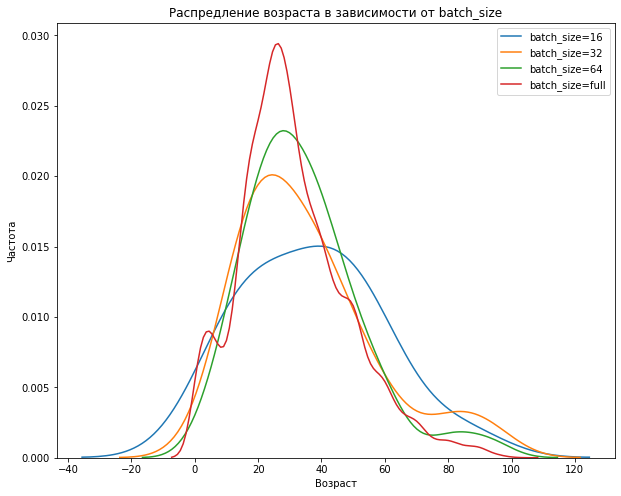

In [2]:
f, ax = plt.subplots(figsize=(10, 8))
for batch in [16,32,64]:
    labels=pd.read_csv(' ')#По правилам Яндекс.Практикум ссылка затерта
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=' ', #По правилам Яндекс.Практикум ссылка затерта
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=batch,
            class_mode='raw',
            seed=12345)
    features, target=next(train_gen_flow)
    value=pd.Series(target)
    snsplot = sns.distplot(value,ax=ax,hist=False,label='batch_size={:.0f}'.format(batch))
    fig = snsplot.get_figure()
snsplot = sns.distplot(labels.real_age,ax=ax,hist=False,label='batch_size=full')
fig = snsplot.get_figure()
ax.legend()
ax.set_xlabel('Возраст');
ax.set_ylabel('Частота');
ax.set_title('Распредление возраста в зависимости от batch_size');

Таким образом видно, что для выборки 16 распределение более гладкое и не затрагивает более взрослого поколения. К тому же оно мало совпадает со всей выборкой. Решением явлется 32 и 64, однако 64 слишком большая выборка и может тормозить процесс обучения, поэтому для дальнейшего обучения выбираем 32.

In [3]:
labels=pd.read_csv(' ') #По правилам Яндекс.Практикум ссылка затерта
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=' ', #По правилам Яндекс.Практикум ссылка затерта
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345)

Found 7591 validated image filenames.


Рассмотрим распределение возрастов в общем датасете.

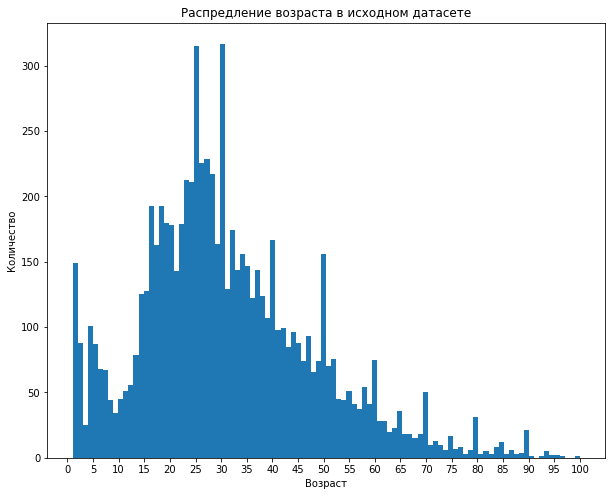

In [4]:
f, ax = plt.subplots(figsize=(10, 8))
value=labels.real_age
plt.hist(x=value,bins=100)
plt.xticks([i+5 for i in range(-5,100,5)]);
ax.set_xlabel('Возраст');
ax.set_ylabel('Количество');
ax.set_title('Распредление возраста в исходном датасете');

Рассмотрим также эти значения на диаграмме размаха

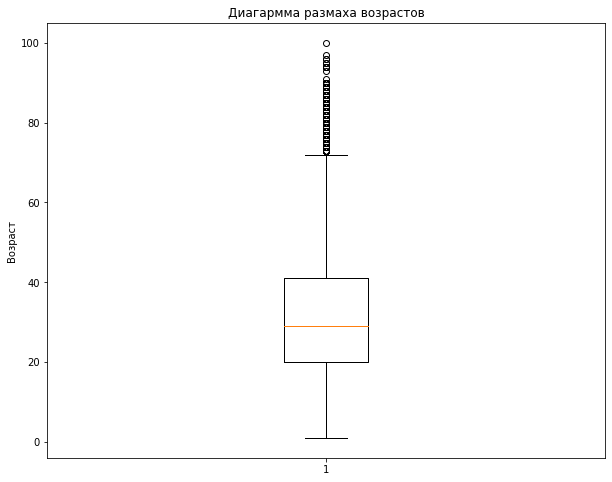

In [5]:
fig,ax=plt.subplots(figsize=(10, 8))
plt.boxplot(labels.real_age);
ax.set_ylabel('Возраст');
ax.set_title('Диагармма размаха возрастов');

Очевидно, что в исходном датасете преобладает группа людей с возрастом от 20 до 40. Причем возраст более 75 является статистическими выбросами. Отсюда следует, что скорей всего модель будет обучаться хорошо на возрасте от 20 до 40, но группа людей с более высоким возрастом будет труднее даваться модели. 

Стоит также отметить, что присутствуют пики на круглых датах после 20 лет. Сбор данных по возрасту зачастую происходит вручную, либо посредством опроса. Лица до 20 лет более подвержены быстрому росту, поэтому разница между 13 и 14 это большая разница, однако после 20, если тебе 24 или 25 разницы особой нет, поэтому удобней округлить в сторону круглой даты.

Рассмотрим фотографии из выборки

In [6]:
features, target=next(train_gen_flow)

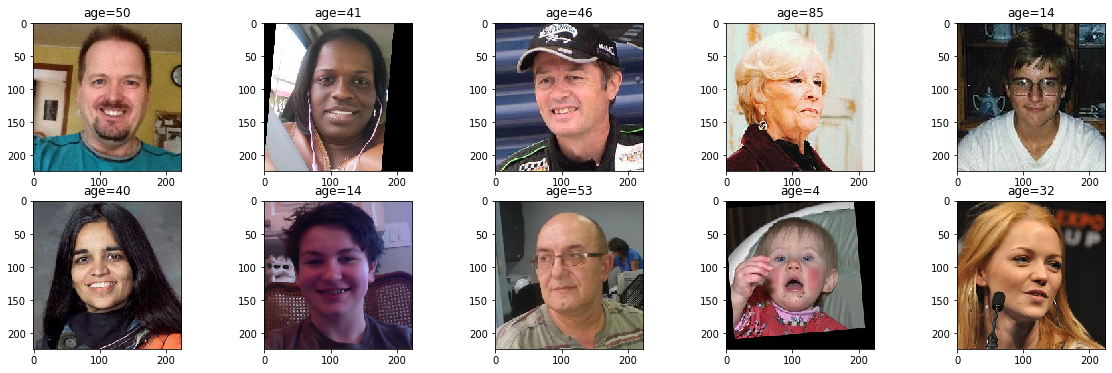

In [7]:
fig=plt.figure(figsize=(20,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(features[i])
    plt.title('age={:.0f}'.format(target[i]))

Как можно заметить, по данным фото аугментация на них уже проведена, поэтому в дальнейшим ее использовать не будем

## Обучение модели

### Подбор параметров

В результате обучения выбрана сеть архитектурой ResNet50. Для обучения модели было использовано несколько моделей. На первом этапе сразу отсекли аугментацию изображения. В исходной выборке присутсвуют фотографии с уже измененными формами. И в результаете применения аугментации на данном датасете, обучение только замедляется.

Следующим этапом было небольшое изменение исходной модели ResNet50. В результате исследование пришел к выводу, что модификации не требуется.

Следующим этапом было подбор количества эпох:

    - 30 эпох, модель справилась, итоговая метрика 5.9. Но обучение проходило очень долго,  к тому же в процессе обучения легко заметить, что модель достигает значение 6,1 уже на 10 эпохе, поэтому следующим этапом была замена количесва эпох на 10;
    - 10 эпох, итоговая метрика 6.1 модель подобрана и обучена. Код данной модели представлен ниже.

Обучение модели происходило на сторонних серверах, поэтому здесь предаставлю код как текстовый файл.


```python
    
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
    
    
    #Загрузка изображений для тренировки и теста
    
path=' ' #Доступ к ссылке ограничен по правилам Яндекс.Практикум
    
train_datagen = ImageDataGenerator(
            rescale=1/255,
            validation_split=0.25

        )

train_data = train_datagen.flow_from_dataframe(
                dataframe=pd.read_csv(path+'/labels.csv'),
                directory=path+'/final_files/',
                x_col='file_name',
                y_col='real_age',
                target_size=(224, 224),
                batch_size=32,
                class_mode='raw',
                subset='training',
                shuffle=True,
                seed=12345)
    
    
test_datagen = ImageDataGenerator(
            rescale=1/255,
            validation_split=0.25
        )
    
    
test_data = test_datagen.flow_from_dataframe(
                dataframe=pd.read_csv(path+'/labels.csv'),
                directory=path+'/final_files/',
                x_col='file_name',
                y_col='real_age',
                target_size=(224, 224),
                batch_size=32,
                class_mode='raw',
                subset='validation',
                shuffle=True,
                seed=12345)
    
    #Создание нейросети
    
backbone = ResNet50(
            input_shape=(224, 224, 3),
            weights=' ',  #По правилам Яндекс.Практикум ссылка затерта
            include_top=False
        )
        
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='relu'))
optimizer = Adam(lr = 0.0001)
model.compile(
            loss='mean_squared_error', 
            optimizer=optimizer, metrics=['mae']
        )
    
        
    
    
    #Создание параметров для обучения
epochs=10
steps_per_epoch=None
validation_steps=None
batch_size=32
    
    
if steps_per_epoch==None:
    steps_per_epoch=len(train_data)
if validation_steps==None:
    validation_steps=len(test_data)
    
            
    #Обучение нейросети
    
    
model.fit(
            train_data, 
            validation_data=(test_data), 
            epochs=epochs,
            steps_per_epoch=steps_per_epoch, 
            batch_size=batch_size,
            validation_steps=validation_steps, 
            verbose=2,
            shuffle=True
    )
    
    
    
```

### Итог модели

Train for 178 steps, validate for 60 steps

Epoch 1/10
178/178 - 46s - loss: 239.0586 - mae: 10.9500 - val_loss: 998.0844 - val_mae: 26.8833

Epoch 2/10

178/178 - 38s - loss: 62.1307 - mae: 5.9313 - val_loss: 882.3279 - val_mae: 24.8017

Epoch 3/10

178/178 - 38s - loss: 29.9950 - mae: 4.1993 - val_loss: 477.9389 - val_mae: 16.6395

Epoch 4/10

178/178 - 38s - loss: 19.2707 - mae: 3.3628 - val_loss: 123.4521 - val_mae: 8.7429

Epoch 5/10

178/178 - 38s - loss: 14.6288 - mae: 2.9434 - val_loss: 87.8359 - val_mae: 7.2921

Epoch 6/10

178/178 - 38s - loss: 12.7445 - mae: 2.7670 - val_loss: 69.3727 - val_mae: 6.3778

Epoch 7/10

178/178 - 38s - loss: 10.9034 - mae: 2.5319 - val_loss: 77.2363 - val_mae: 6.5110

Epoch 8/10

178/178 - 37s - loss: 9.2121 - mae: 2.3046 - val_loss: 71.5637 - val_mae: 6.2993

Epoch 9/10

178/178 - 37s - loss: 8.6649 - mae: 2.2347 - val_loss: 70.3464 - val_mae: 6.2169

Epoch 10/10

178/178 - 38s - loss: 7.6518 - mae: 2.1101 - val_loss: 64.4174 - val_mae: 6.1639
60/60 - 9s - loss: 64.4174 - mae: 6.1639

Test MAE: 6.1639


Таким образом итоговое значение MAE для модели 6,163

## Анализ обученной модели

В результате обучения использоавлась нейронная сеть архитектурой ResNet50 c 1 нейроном в выходном слое с функцией активации ReLu. Алгоритм обучения применялся Adam c шагом learning_rate=0.0001.Количество эпох для обучения 10. Обучение проводилось на фотографиях 224x224. Аугментация изображений не проводилась, так как в исходном датасете она уже применялась. В качестве функции потерь выступала mean_squared_error, так как с ней обучение проводилось быстрее. В качестве итоговой метрики выбрана MAE с результатом 6,163

В процессе анализа датасета для обучения замечено, что в исходном датасете преобладают фотографии людей от 20 до 40 лет, причем с выбросами после 75 лет. Соотвественно из за явного дисбаланса модель будет плохо обучаться на людях после 75. Однако я не считаю это большой проблемой для исходной задачи. Разберем попунктно.

    - Продажа алкогольной продукции несовершеннолетним.
    
    Фотографий до 21 года достаточно, что бы отгородить продажу для несовершеннолетних, отсюда следует, что некорректное опредление возрасата после 75 не повлияет на опредление возраста до 21.
    
    -Рекомендации товаров конкретной группе по возрасту.
    
    Модель получила хорошее значение метрики, отсюда следует, что опредление возраста работает хорошо. Сокрей всего люди после 65 и дальше в сетевом магазине попадут в одну группу покупателей, поэтому в данном случае неправильное опредление возраста не нарушит рекомендательную систему. Но необходимо провети дополнительное исследование, совпадает ли распределение возрастов в датасете с реальными посетителями супермаркета. Например возраст можно определить по картам лояльности  (так как в задание оговорено, что это крупная сеть, то скорей всего данная сеть имеет карты лояльности)
    